# Extract CMIP6 climate data for island nations

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import xesmf as xe
import intake
from xmip.postprocessing import pick_first_member, concat_experiments
from xmip.preprocessing import combined_preprocessing

## Lazy loading CMIP6 models in the cloud

For more information see our [cmip6-feedstock](https://github.com/leap-stc/cmip6-leap-feedstock#how-to-access-the-newly-uploaded-data) and the [Pangeo CMIP6 Cloud Data Docs](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection)

In [9]:
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" 
col = intake.open_esm_datastore(url)

# search only for a subset of the full collection
cat = col.search(
    variable_id='tas',  #surface air temperature (find more variables and the specific names here: 
                        #https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit?pli=1&gid=1221485271#gid=1221485271
    experiment_id=['ssp245','ssp585'],  # extract a middle of the road, and business as usual scenario: 
                                        # more info here: https://en.wikipedia.org/wiki/Shared_Socioeconomic_Pathways
    grid_label='gn', # chose the native model grid (vs regridded products)
    table_id = 'Amon', # monthly output frequency
    source_id = ['ACCESS-ESM1-5'] # For simplicity choose only two models (omit this line if you want to explore all of the climate models available)
)

In [10]:
# Load all xarray datasets into a dictionary, and apply xmip (https://github.com/jbusecke/xMIP) preprocessing to align naming and other common cleaning tasks
ddict = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    aggregate=False,
    xarray_open_kwargs={'use_cftime':True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


In [13]:
from xmip.postprocessing import concat_members
import dask

In [47]:
# Some members run beyond 2100, prune the time to facilitate alignment
ddict_pruned = {k:ds.sel(time=slice(None, '2100')).squeeze() for k,ds in ddict.items()}
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ddict_members_combined = concat_members(ddict_pruned)

In [48]:
# note how you have a new dimension 'member_id' indicating that we have 10 ensemble members
ddict_members_combined['ACCESS-ESM1-5.gn.ssp245.Amon.tas']

<xarray.Dataset> Size: 1GB
Dimensions:            (member_id: 10, time: 1032, y: 145, x: 192, bnds: 2,
                        vertex: 4)
Coordinates: (12/14)
  * member_id          (member_id) object 80B 'r34i1p1f1' ... 'r31i1p1f1'
    height             float64 8B 2.0
  * y                  (y) float64 1kB -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
  * x                  (x) float64 2kB 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time               (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 1...
    time_bounds        (time, bnds) object 17kB 2015-01-01 00:00:00 ... 2101-...
    ...                 ...
    lon                (x, y) float64 223kB 360.0 360.0 360.0 ... 358.1 358.1
    lat                (x, y) float64 223kB -90.0 -88.75 -87.5 ... 88.75 90.0
    lon_verticies      (vertex, x, y) float64 891kB 359.1 359.1 ... 359.1 359.1
    lat_verticies      (vertex, x, y) float64 891kB -90.0 -89.38 ... 88.12 89.38
    variant_label      (member_id) <U9 360B 'r34i1p1f1' ... 'r31i1p1f1'
    sub_experiment_id  <U4 16B 'none'
Dimensions without coordinates: bnds, vertex
Data variables:
    tas                (member_id, time, y, x) float32 1GB dask.array<chunksize=(1, 516, 145, 192), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                         CF-1.7 CMIP-6.2
    activity_id:                         ScenarioMIP
    branch_method:                       standard
    branch_time_in_child:                60265.0
    branch_time_in_parent:               60265.0
    cmor_version:                        3.4.0
    ...                                  ...
    intake_esm_attrs:table_id:           Amon
    intake_esm_attrs:variable_id:        tas
    intake_esm_attrs:grid_label:         gn
    intake_esm_attrs:sub_experiment_id:  none
    intake_esm_attrs:version:            v20210712
    intake_esm_attrs:_data_format_:      zarr

In [49]:
# convert cell bound conventions compatible with out regridder (xesmf)

In [50]:
import cf_xarray
# special processing for xesmf: the lat/lon bounds need to be in the
def convert_bounds(ds):
    ds = ds.copy()
    """Produces lon/lat bounds in the appropriate format for xESMF"""
    ## for this we actually need to use the vertices (need to correct that typo!) variable (which indicates the 4 corners of the cell)
    lon_vert = ds.lon_verticies.load()
    lat_vert = ds.lat_verticies.load()
    
    # drop the old bounds to avoid confusion
    ds = ds.drop(['lon_bounds', 'lat_bounds'])
    
    # convert using cf_xarray
    lon_bounds = cf_xarray.bounds_to_vertices(lon_vert, 'vertex')
    lat_bounds = cf_xarray.bounds_to_vertices(lat_vert, 'vertex')
    
    ds = ds.assign_coords(lon_b=lon_bounds, lat_b=lat_bounds)
    return ds

ddict_fixed_bounds = {k:convert_bounds(ds) for k,ds in ddict_members_combined.items()}

/tmp/ipykernel_1251/2173723817.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['lon_bounds', 'lat_bounds'])


## Load island geometry and regrid coarse climate model output

The geometry that is loaded was picked at random (and does not include all the desired islands). This needs some further research to find appropriate input data. Just using the below as an example.

In [51]:
import geopandas as gpd
countries = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')
# filter out some of the islands we are interested int
study_countries = countries[countries['sovereignt'].isin(['Fiji', 'Solomon Islands', 'Marshall Islands'])] # not all cou
study_countries

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
53,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,0,...,Oceania,Melanesia,East Asia & Pacific,4,4,4,-99,1,Admin-0 country,"MULTIPOLYGON (((178.37360 -17.33992, 178.71806..."
142,1,3,Solomon Islands,SLB,0,2,Sovereign country,Solomon Islands,SLB,0,...,Oceania,Melanesia,East Asia & Pacific,11,15,6,-99,1,Admin-0 country,"MULTIPOLYGON (((162.11902 -10.48272, 162.39865..."


In [78]:
def extract_on_geometry(ds: xr.Dataset, countries: gpd.geodataframe.GeoDataFrame)-> tuple[xr.Dataset, xr.DataArray]:
    # create spatial regridder for every source_id (and plot how well these islands are represented
    savg = xe.SpatialAverager(ds, countries.geometry)
    out = savg(ds).rename({'geom':'country'})
    out = out.assign_coords(country=xr.DataArray(study_countries['sovereignt'].values, dims=['country']))
    # create the weights to confirm which grid cells are used to construct the average
    w = xr.DataArray(
        savg.weights.data.todense().reshape(countries.geometry.size, *ds.lon.shape),
        dims=("country", *ds.lon.dims),
        coords=dict(state='country_dim', **ds.lon.coords),
    )
    out.attrs = ds.attrs|out.attrs
    return out, w

In [79]:
ddict_extracted = {k:extract_on_geometry(ds, study_countries) for k,ds in ddict_fixed_bounds.items()}

/srv/conda/envs/notebook/lib/python3.11/site-packages/xesmf/frontend.py:1220: UserWarning: `polys` contains large (> 1°) segments. This could lead to errors over large regions. For a more accurate average, segmentize (densify) your shapes with  `shapely.segmentize(polys, 1)`
  self._check_polys_length(polys)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xesmf/frontend.py:1220: UserWarning: `polys` contains large (> 1°) segments. This could lead to errors over large regions. For a more accurate average, segmentize (densify) your shapes with  `shapely.segmentize(polys, 1)`
  self._check_polys_length(polys)


## A word of caution: These climate model outputs are very coarse!
An example visualization of the grid cells that are used to construct the average timeseries

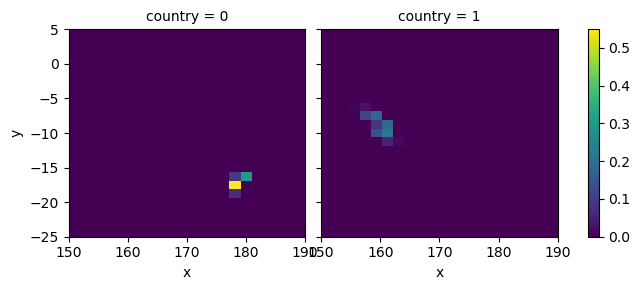

In [80]:
# visualize the weights
p = ddict_extracted['ACCESS-ESM1-5.gn.ssp585.Amon.tas'][1].plot(col='country', x='x', y='y')
for ax in p.axs.flat:
    ax.set_ylim(-25, 5)
    ax.set_xlim(150, 190)

## Vizualizing what we have

In [81]:
from dask.diagnostics import ProgressBar

In [82]:
with ProgressBar():
    timeseries = {k:a[0].squeeze().load() for k,a in ddict_extracted.items()}

[########################################] | 100% Completed | 1.52 sms
[########################################] | 100% Completed | 4.86 ss


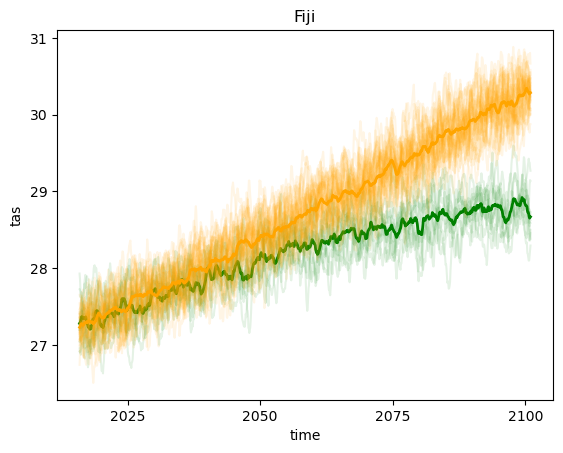

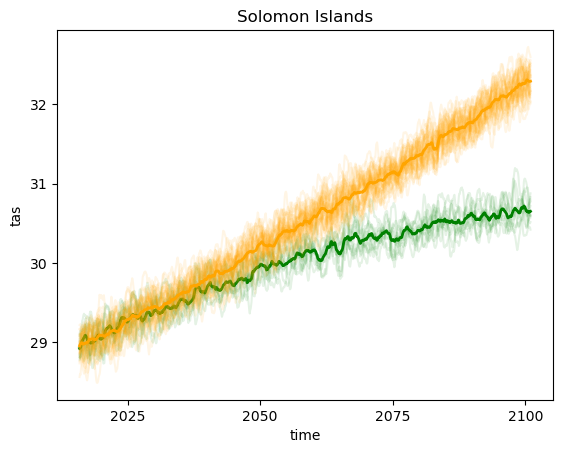

In [99]:
import matplotlib.pyplot as plt
color_dict = {'ssp245':'green', 'ssp585':'orange'}

for country in ['Fiji', 'Solomon Islands']:
    plt.figure()
    for k,ds in timeseries.items():
        ds_country = ds.sel(country=country).rolling(time=12).mean() # take a rolling average to remove the seasonal cycle
        temp = ds_country.tas -273.15 # convert to celcius
        temp.plot(hue='member_id', color=color_dict[ds.attrs['experiment_id']], add_legend=False, alpha=0.1)
        temp.mean('member_id').plot(lw=2, color=color_dict[ds.attrs['experiment_id']], add_legend=False)
    plt.title(country)

**NOTE**: This is only a single model showing the range of predicted values due to internal variability (chaotic behavior of the climate system). For a thorough assesment you want to look at multiple models!